In [1]:
import sys

%cd ..
# add the src directory for the code
sys.path.append('src')

%cd .
sys.path.append('cdml-neurips2020/datasets')

/home/nikolas/Downloads/CS-673 (23-24)/Project/msft_causica
/home/nikolas/Downloads/CS-673 (23-24)/Project/msft_causica


In [2]:
import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch

from pytorch_lightning.callbacks import TQDMProgressBar
from tensordict import TensorDict

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, Variable
from causica.distributions import ContinuousNoiseDist
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.sem_distribution import SEMDistributionModule
from causica.sem.structural_equation_model import ite
from causica.training.auglag import AugLagLRConfig

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script

print(np.__version__)

1.23.5


In [30]:
CAUSICA_DATASETS_PATH = '../cdml-neurips2020/'
root_path = CAUSICA_DATASETS_PATH + 'datasets/'

FILENAME = 'Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 10000 Noise 0.01 0.1' + '-lagged.csv'

In [31]:
df = pd.read_csv(root_path + FILENAME)

# drop a handful of samples
#df = df[:5000]
display(df)
print("Data Shape:", df.shape)

,X1,X2,X3,Y1,X1:1,X2:1,X3:1,Y1:1
0,0.602888,-0.317144,0.123986,0.054386,-0.333167,0.120291,-0.313161,0.782941
1,0.147428,-0.353617,-0.298057,0.985789,0.602888,-0.317144,0.123986,0.054386
2,0.169421,-0.023562,-0.508075,1.020029,0.147428,-0.353617,-0.298057,0.985789
3,-0.271752,-0.040821,-0.799066,0.660175,0.169421,-0.023562,-0.508075,1.020029
4,-0.020856,0.052620,-0.137816,0.668248,-0.271752,-0.040821,-0.799066,0.660175
...,...,...,...,...,...,...,...,...
9994,-0.007770,0.335393,-0.624249,0.750741,-0.058260,-0.017507,-0.249589,0.781348
9995,0.116234,0.002977,-1.017827,0.495584,-0.007770,0.335393,-0.624249,0.750741
9996,0.109565,0.181715,-1.131179,1.136734,0.116234,0.002977,-1.017827,0.495584
9997,-0.180192,0.378420,-0.807047,0.915629,0.109565,0.181715,-1.131179,1.136734


Data Shape: (9999, 8)


In [32]:
# load metadata telling us the data type of each column
# create the variables_spec json file from the dataframe 

variables_spec= []
for col in df.columns:
    variables_spec.append({"name": col, "type": "continuous", "group_name": col})

variables_path = root_path + FILENAME.replace('.csv', '.json')
with fsspec.open(variables_path, mode="w", encoding="utf-8") as f:
    json.dump({"variables": variables_spec}, f, indent=2)
        
with fsspec.open(variables_path, mode="r", encoding="utf-8") as f:
    variables_spec = json.load(f)["variables"]

print("Variables Spec:", variables_spec)

Variables Spec: [{'name': 'X1', 'type': 'continuous', 'group_name': 'X1'}, {'name': 'X2', 'type': 'continuous', 'group_name': 'X2'}, {'name': 'X3', 'type': 'continuous', 'group_name': 'X3'}, {'name': 'Y1', 'type': 'continuous', 'group_name': 'Y1'}, {'name': 'X1:1', 'type': 'continuous', 'group_name': 'X1:1'}, {'name': 'X2:1', 'type': 'continuous', 'group_name': 'X2:1'}, {'name': 'X3:1', 'type': 'continuous', 'group_name': 'X3:1'}, {'name': 'Y1:1', 'type': 'continuous', 'group_name': 'Y1:1'}]


Initialize a DECI model

In [33]:
data_module = BasicDECIDataModule(
    dataframe=df,
    variables=[Variable.from_dict(v) for v in variables_spec],
    batch_size=64,
    normalize=True 
)
num_nodes = len(data_module.dataset_train.keys())

display(data_module.dataset_train.keys()) # sanity check

_StringKeys({'X1': tensor([[ 2.1358],
        [ 0.5267],
        [ 0.6044],
        ...,
        [ 0.3930],
        [-0.6307],
        [-1.8364]]), 'X2': tensor([[-1.6524],
        [-1.8407],
        [-0.1364],
        ...,
        [ 0.9236],
        [ 1.9394],
        [ 0.8188]]), 'X3': tensor([[ 2.0899],
        [ 0.6200],
        [-0.1115],
        ...,
        [-2.2818],
        [-1.1529],
        [-1.5832]]), 'Y1': tensor([[-1.7717],
        [ 0.8775],
        [ 0.9748],
        ...,
        [ 1.3068],
        [ 0.6779],
        [-1.0201]]), 'X1:1': tensor([[-1.1713],
        [ 2.1359],
        [ 0.5267],
        ...,
        [ 0.4165],
        [ 0.3929],
        [-0.6308]]), 'X2:1': tensor([[ 6.0647e-01],
        [-1.6524e+00],
        [-1.8407e+00],
        ...,
        [ 6.7863e-04],
        [ 9.2365e-01],
        [ 1.9394e+00]]), 'X3:1': tensor([[ 0.5672],
        [ 2.0900],
        [ 0.6198],
        ...,
        [-1.8875],
        [-2.2823],
        [-1.1532]]), 'Y1:1': tens

In [34]:
print(f'Number of nodes: {num_nodes}') # sanity check

Number of nodes: 8


In [35]:
outcome = "Y1"

node_name_to_idx = {key: i for i, key in enumerate(data_module.dataset_train.keys())}
node_names = list(data_module.dataset_train.keys())

print(f'Node names: {node_names}')
num_nodes = len(node_names)

# extract the maximum lag available
max_lag = max([int(node.split(":")[1]) for node in node_names if ":" in node])
print(f'Max Lag: {max_lag}')

constraint_matrix = np.full((num_nodes, num_nodes), np.nan, dtype=np.float32)  # init constraint matrix with NaNs

lagged_nodes = [node for node in node_names if ":" in node]  # find all lagged nodes
print(f'Lagged nodes: {lagged_nodes}')

non_lagged_nodes = [node for node in node_names if node not in lagged_nodes]  # find all non-lagged nodes
print(f'Non-lagged nodes: {non_lagged_nodes}')

Node names: ['X1', 'X2', 'X3', 'Y1', 'X1:1', 'X2:1', 'X3:1', 'Y1:1']
Max Lag: 1
Lagged nodes: ['X1:1', 'X2:1', 'X3:1', 'Y1:1']
Non-lagged nodes: ['X1', 'X2', 'X3', 'Y1']


Proceed with adding time-series related constraints as prior knowledge (represented as a constraint matrix).

In [36]:
#no self loops
constraint_matrix[np.diag_indices(num_nodes)] = 0

for node in node_names:
    for node_2 in node_names:
        suffix = node.split(":")[1] if ":" in node else None
        suffix_2 = node_2.split(":")[1] if ":" in node_2 else None
        if suffix is not None and suffix_2 is not None and suffix == suffix_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
for node in node_names:
    prefix = node.split(":")[0]
    if ":" not in node:
        constraint_matrix[node_name_to_idx[node], :] = 0 # final timestep has no children
    #print("Node:", node, "Prefix:", prefix)
    for node_2 in node_names:
        prefix_2 = node_2.split(":")[0]
        if prefix == prefix_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
        if ":" in node_2 and prefix == node_2.split(":")[1]:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
        #no edges back to previous time steps
        if ":" in node and ":" in node_2 and int(node.split(":")[1]) < int(node_2.split(":")[1]):
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
        if ":" not in node and ":" in node_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0            
        
# target node (outcome) has no children
constraint_matrix[node_name_to_idx[outcome], :] = 0
for i in range(1, max_lag + 1):
    constraint_matrix[node_name_to_idx[str(outcome) + ":" + str(i)], :] = 0

constraint_df = pd.DataFrame(constraint_matrix, index=node_names, columns=node_names)

print("Constraint Matrix:")
display(constraint_df)

Constraint Matrix:


,X1,X2,X3,Y1,X1:1,X2:1,X3:1,Y1:1
X1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1:1,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
X2:1,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
X3:1,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
Y1:1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The number of edges to be learned during training is greatly reduced (the ones set to zero) due to the introduced constraints. 

E.g the DECI model now has to learn the existence and SEM parametrization of $X1:1 \rightarrow X_2$, $X3:1 \rightarrow Y_1$ etc.

In [37]:
pl.seed_everything(seed=42)  # set the random seed

lightning_module = DECIModule(
    noise_dist=ContinuousNoiseDist.SPLINE, # or ContinuousNoiseDist.GAUSSIAN for Gaussian noise
    embedding_size=64, # default
    out_dim_g=3, # default
    num_layers_g=3, # 2 is default
    num_layers_zeta=3, # 2 is default
    gumbel_temp=10, # default
    prior_sparsity_lambda=1.0,
    init_rho=1.0,
    init_alpha=0.020,
    auglag_config=AugLagLRConfig(
        max_inner_steps=1500,
        max_outer_steps=8,
        lr_init_dict={
            "icgnn": 0.00076,
            "vardist": 0.0098,
            "functional_relationships": 3e-3,
            "noise_dist": 0.0070,
        },
    ),
)

lightning_module.constraint_matrix = torch.tensor(constraint_matrix)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=3000,
    fast_dev_run=test_run,
    callbacks=[TQDMProgressBar(refresh_rate=19)],
    enable_checkpointing=False
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Thankfully for us, the trainer of Pytorch lightning runs on all available GPUs (one in our case) by default.

In [38]:
display(type(lightning_module))
display(lightning_module)

causica.lightning.modules.deci_module.DECIModule

DECIModule(
  (auglag_loss): AugLagLossCalculator()
)

We may also use tensorboard to track values over epochs such as the training loss:

In [39]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [40]:
trainer.fit(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 28.1 K
------------------------------------------------------
28.0 K    Trainable params
64        Non-trainable params
28.1 K    Total params
0.112     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Updating alpha to: 0.09999999403953552
Updating alpha to: 0.4999999701976776
Updating alpha to: 2.499999761581421
Updating alpha to: 12.499999046325684
Updating alpha to: 62.499996185302734


We pickle the learned SEM model:

In [47]:
torch.save(lightning_module.sem_module, "deci_learned_SEM.pt")

#### Plot the inferred causal DAG 

In [48]:
sem_module: SEMDistributionModule = torch.load("deci_learned_SEM.pt")

# create a structural equation model using the most likely graph
sem = sem_module().mode

['X1', 'X2', 'X3', 'Y1', 'X1:1', 'X2:1', 'X3:1', 'Y1:1']


{'X1': 'X1',
 'X2': 'X2',
 'X3': 'X3',
 'Y1': 'Y1',
 'X1:1': 'X1:1',
 'X2:1': 'X2:1',
 'X3:1': 'X3:1',
 'Y1:1': 'Y1:1'}

'Number of edges: 4'

networkx.classes.digraph.DiGraph

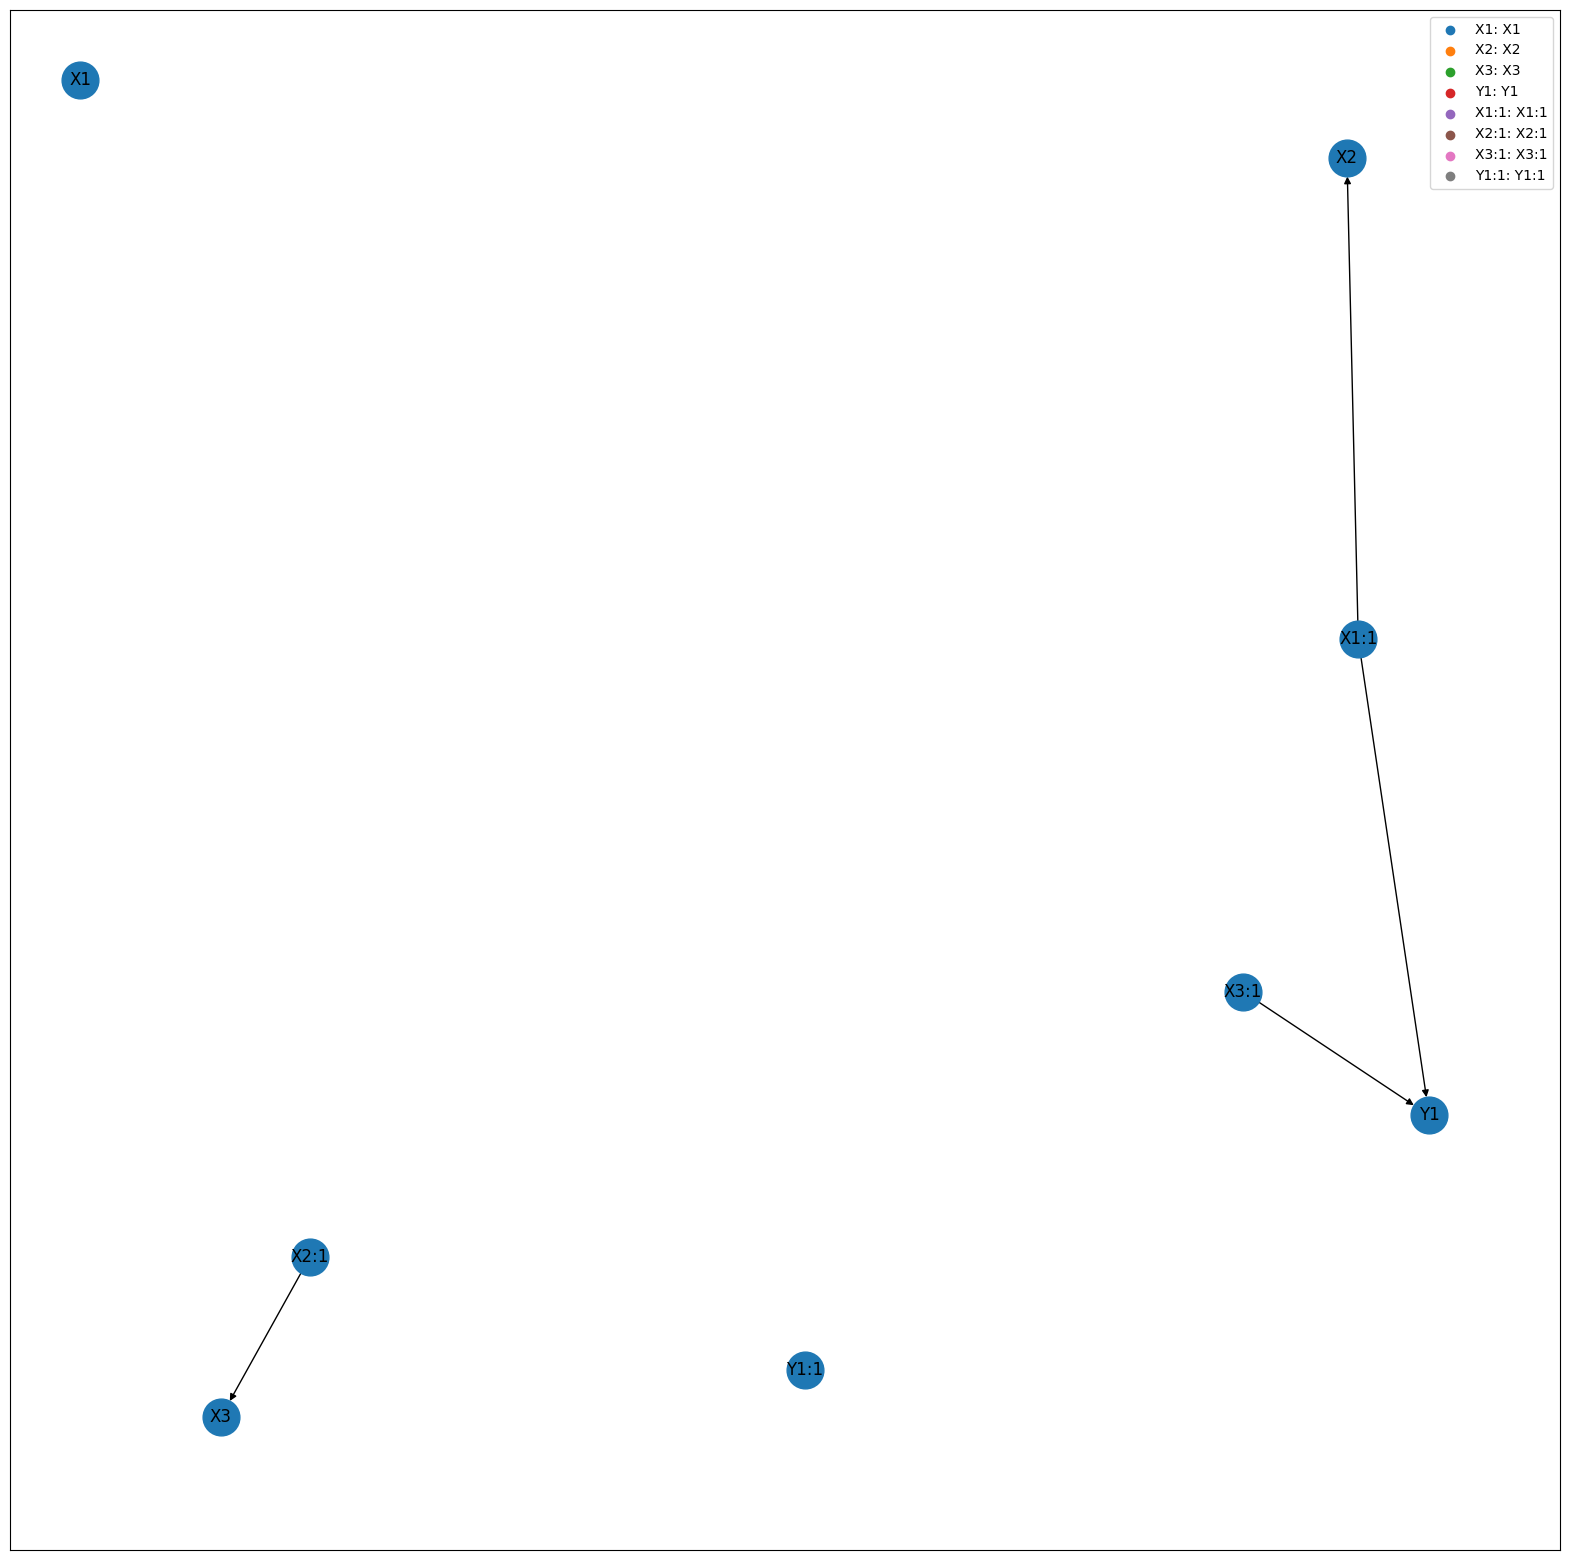

In [49]:
# Create the graph from sem.graph
graph_array = sem.graph.cpu().numpy()

graph = nx.from_numpy_array(graph_array, create_using=nx.DiGraph)
#graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))
graph = nx.relabel_nodes(graph, {i: key for i, key in enumerate(data_module.dataset_train.keys())})

# sanity check
#print(dict(data_module.dataset_train.keys()))
#print(list(data_module.dataset_train.keys()))

print(graph.nodes)

# Prepare the plot
fig, axis = plt.subplots(1, 1, figsize=(20, 20))

# Set labels for nodes
#labels = {node: i for i, node in enumerate(graph.nodes)}
labels = {node: node for node in graph.nodes}
display(labels)

display(f'Number of edges: {len(graph.edges)}')

# Try to use graphviz layout, fallback to spring layout if not available
try:
    layout = nx.nx_agraph.graphviz_layout(graph, prog="dot")
except (ModuleNotFoundError, ImportError):
    layout = nx.layout.spring_layout(graph)

# Scatter plot nodes
for node, i in labels.items():
    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
axis.legend()

# Draw the networkx graph
nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

display(type(graph))
plt.show()

#### Compare inferred graph with pickled ground truth

In [50]:

# Load the graph from the pickle file
GRAPH_FILENAME = root_path + FILENAME.split('-')[0] + '-causal_graph.pkl'
with open(GRAPH_FILENAME, 'rb') as f:
    gt_graph = pickle.load(f) 

type(gt_graph)

#graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))

# sanity checks
#display(gt_graph.nodes)
#display(gt_graph.edges)

#remove nodes starting with S
for node in list(gt_graph.nodes):
    if  node.startswith('S'):
        gt_graph.remove_node(node)
#display(gt_graph.nodes)

#same for edges
for edge in list(gt_graph.edges):
    if edge[0].startswith('S') or edge[1].startswith('S'):
        gt_graph.remove_edge(edge[0], edge[1])
display(gt_graph.edges)

#rename nodes from X_t-1 to X:1 etc
for node in list(gt_graph.nodes):
    dict = { node: node.replace('_t', '').replace('_', '_').replace(':1', ':1').replace('-', ':')}
    gt_graph = nx.relabel_nodes(gt_graph, dict)

display(gt_graph.nodes)


OutEdgeView([('X1_t-1', 'Y1_t'), ('X2_t-1', 'X3_t')])

NodeView(('Y1', 'Y1:1', 'X1', 'X1:1', 'X2', 'X2:1', 'X3', 'X3:1'))

#### Plot the ground-truth graph 

Number of edges: 2


networkx.classes.digraph.DiGraph

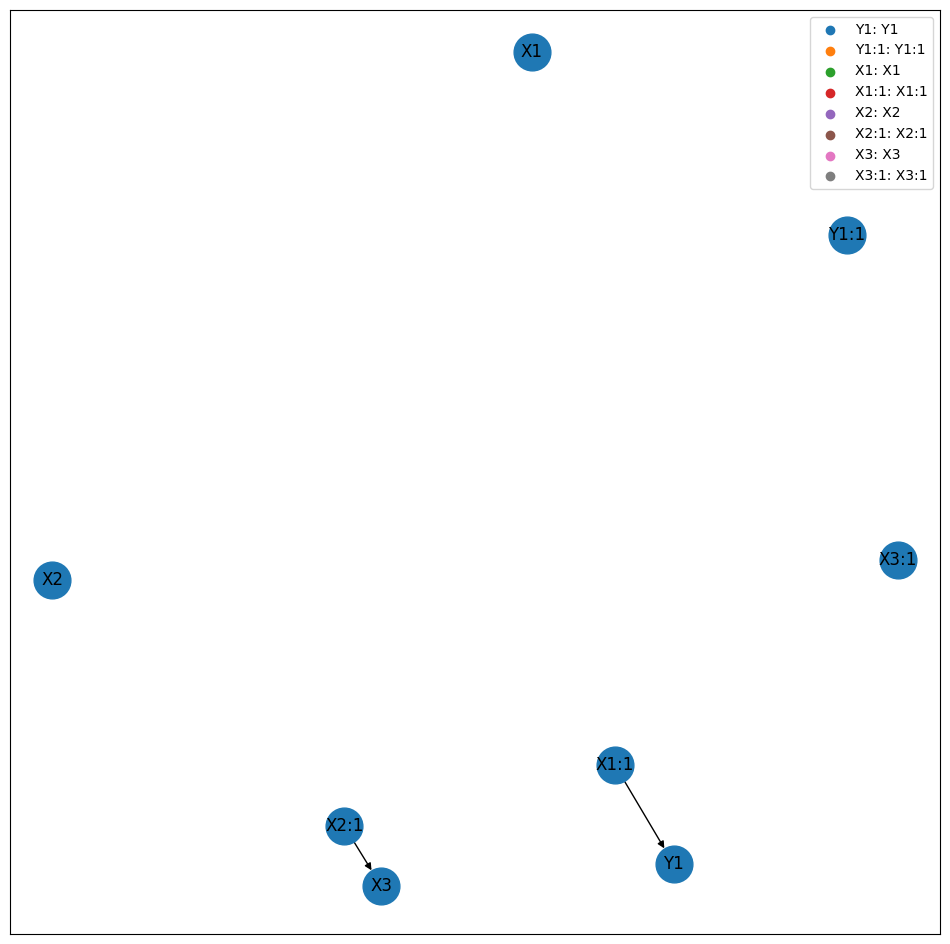

In [51]:
fig, axis = plt.subplots(1, 1, figsize=(12, 12))

labels = {node: node for node in gt_graph.nodes}
#display(labels)

#rename nodes from X_t-1 to X:1 etc
for node in list(gt_graph.nodes):
    dict = { node: node.replace('_t', '').replace('_', '_').replace(':1', ':1').replace('-', ':')}
    gt_graph = nx.relabel_nodes(gt_graph, dict)

# sanity checks
#display(gt_graph.nodes)
#display(gt_graph.edges)

#display(graph.nodes)
#display(graph.edges)

print("Number of edges:", len(gt_graph.edges))

try:
    layout = nx.nx_agraph.graphviz_layout(graph, prog="dot")
except (ModuleNotFoundError, ImportError):
    layout = nx.layout.spring_layout(gt_graph)

for node, i in labels.items():
    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
axis.legend()

nx.draw_networkx(gt_graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

display(type(gt_graph))
plt.show()

#### Compute performance metrics

In [52]:
import cdt #causal discovery toolbox

display(f'SHD: {cdt.metrics.SHD(gt_graph, graph, double_for_anticausal=True)}')

aupr, curve = cdt.metrics.precision_recall(gt_graph, graph, low_confidence_undirected=True)

display(f'Precision-Recall AUC: {aupr}, Curve: {curve}')

sid = cdt.metrics.SID(graph, gt_graph) #depends on the R-package SID
display(f'SID: {sid}')

'SHD: 2'

'Precision-Recall AUC: 0.75, Curve: [(0.5, 1.0), (1.0, 0.0)]'

'SID: 3.0'